In [ ]:
from scipy.optimize import line_search
from scipy.special import gamma,digamma,gammaln
import numpy as np
import math
import cupy as cp
from scipy.optimize import minimize

In [ ]:
def multivariate_student_t(X, mu, Sigma, df):    
    #multivariate student T distribution
    #Multivariate t-student density:
    #output:
     #   the density of the given element
    #input:
     #   x = parameter (d dimensional numpy array or scalar)
      #  mu = mean (d dimensional numpy array or scalar)
       # Sigma
        #df = degrees of freedom
        #d: dimension
    [n,d] = X.shape
    Xm = X-mu
    V = df * Sigma
    V_inv=cp.linalg.inv(V)
    
    logdet = cp.log(cp.linalg.det(math.pi * V))

    logz =  0.5*logdet-gammaln(df/2.0 + d/2.0) +gammaln(df/2.0) +0.5*d*math.log(df*math.pi)
    logp = -0.5*(df+d)*cp.log(1+ cp.sum(cp.multiply(cp.matmul(Xm,V_inv),Xm),1))

    logp = logp - logz            

    return logp#,logz,logdet

In [ ]:
class tMixture:

    def __init__(self, n_components: int = 1, reg_covar: float = 1e-08, max_iter: int = 300, initial="kmeans"):

        self.n_components = n_components

        self.means_ = None

        self.covariances_ = None

        self.weights_ = None

        self.reg_covar = reg_covar  # 该参数是为了防止出现奇异协方差矩阵

        self.max_iter = max_iter
        self.initial=initial
        

    
    def fit(self,X_u):#fit(self, X_l,X_u,y_l):

        # 获取一些必要的数据信息

      
        n_samples, n_feature = X_u.shape
        n_u=n_samples
        self.reg_covar = self.reg_covar * cp.identity(n_feature)
        # 初始化一些必要的参数：均值，协方差，权重
        self.v=0.01*np.ones(self.n_components)
        self.means_= cp.random.randint(X_u.min() / 2, X_u.max() /

                                        2, size=(self.n_components, n_feature))


        self.weights_ = cp.ones(self.n_components) / self.n_components
        self.covariances_ = cp.zeros((self.n_components, n_feature, n_feature))
        if self.initial=="kmeans":
            kmeans = KMeans(init="random",n_clusters=self.n_components,n_init=10,max_iter=300,random_state=42)
            x_train=cp.asnumpy(X_u)
            kmeans.fit(x_train)
            self.means_=cp.asarray(kmeans.cluster_centers_)
            label=kmeans.labels_
            for k in range(self.n_components):
                self.covariances_[k]=cp.cov(X_u[label==k].transpose())
               
                self.weights_[k] = (label == k).sum() / n_samples
        else:

            for k in range(self.n_components):

                cp.fill_diagonal(self.covariances_[k], 1)

        E_u_nk=cp.ones((n_samples, self.n_components))
        q_nk = cp.zeros((n_samples, self.n_components)) 
        for it in range(self.max_iter):
            #### E-step，计算概率 ####  sigma_z mu_z
            #ctime1 = time.time()
            qyx_old=cp.copy(q_nk) 
            print("n",self.n_components)
            for k in range(self.n_components):
                up=n_feature+self.v[k]
                Xm=X_u-self.means_[k].reshape(1,-1)
                down=cp.sum(cp.multiply(cp.matmul(Xm,self.covariances_[k]),Xm),1)+self.v[k]
                E_u_nk[:,k]=up/down#<u_nk> Expectation of u_nk
                q_nk[:,k]=math.log(self.weights_[k]+1e-40)+multivariate_student_t(X_u, self.means_[k], self.covariances_[k], self.v[k])#logq_nk
               
            myMax = q_nk.max(axis=1).reshape((n_u, 1)) 
            print(cp.sum((cp.max(q_nk,1))),"loglikelihood")
            q_nk = q_nk - myMax - cp.reshape(np.log(np.exp(q_nk - myMax).sum(axis=1)), (n_u, 1))  #logq_nk  normalized
            #print(q_nk,"logR")
            q_nk=cp.exp(q_nk)
            #print(cp.sum(cp.log(cp.sum(q_nk,1))),"loglikelihood")
            #q_nk=cp.divide(q_nk,cp.sum(q_nk,1).reshape(-1,1))
            
            
            dif_1=cp.linalg.norm(cp.subtract(qyx_old,q_nk),ord=1,keepdims=True)
            print(dif_1)
            #### M-step
            #### M-step，更新参数 ####
            P_mat=cp.multiply(q_nk,E_u_nk)
            for k in range(self.n_components):

                N_k = cp.sum(P_mat[:, k])  # 类出现的频率
                n_k=cp.sum(q_nk[:,k])
                self.means_[k] = (1 / N_k) * cp.sum(X_u *

                                                    P_mat[:, k].reshape(-1, 1), axis=0)  # 该类的新均值

                self.covariances_[k] = (1 / n_k) * cp.dot((P_mat[:, k].reshape(-1, 1)

                                                           * (X_u - self.means_[k])).T,

                                                          (X_u - self.means_[k])) + self.reg_covar

                self.weights_[k] = n_k / n_samples
       
    def predict(self,X_u):  
        n_u,n_feature  =X_u.shape
        q_nk=cp.divide(cp.ones((n_u, self.n_components)),self.n_components)
        for k in range(self.n_components):        
                q_nk[:,k]=math.log(self.weights_[k]+1e-40)+multivariate_student_t(X_u, self.means_[k], self.covariances_[k], self.v[k])#logq_nk
               
        myMax = q_nk.max(axis=1).reshape((n_u, 1)) 
        print(cp.sum((cp.max(q_nk,1))),"loglikelihood")
        q_nk = q_nk - myMax - cp.reshape(np.log(np.exp(q_nk - myMax).sum(axis=1)), (n_u, 1))  #logq_nk  normalized
           
        q_nk=cp.exp(q_nk)
        return cp.argmax(q_nk,1) 

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
tmm = tMixture(n_components=4)
import cupy as cp
from sklearn.cluster import KMeans
import math

In [ ]:
tmm.fit(cp.asarray(X))

n 4
-2657.113597528728 loglikelihood
[[101.26369103]]
n 4
-2667.5071622958208 loglikelihood
[[1.22684517]]
n 4
-2667.957758653396 loglikelihood
[[0.29765861]]
n 4
-2668.0677739058415 loglikelihood
[[0.13980605]]
n 4
-2668.09578927754 loglikelihood
[[0.07304147]]
n 4
-2668.10679221652 loglikelihood
[[0.03955386]]
n 4
-2668.1125453460404 loglikelihood
[[0.02202787]]
n 4
-2668.11589315316 loglikelihood
[[0.01248677]]
n 4
-2668.117873945222 loglikelihood
[[0.0070971]]
n 4
-2668.119036999326 loglikelihood
[[0.0040351]]
n 4
-2668.119712931197 loglikelihood
[[0.00229435]]
n 4
-2668.120102644295 loglikelihood
[[0.00130458]]
n 4
-2668.120326135423 loglikelihood
[[0.00074179]]
n 4
-2668.1204538684547 loglikelihood
[[0.00042178]]
n 4
-2668.120526720697 loglikelihood
[[0.00023983]]
n 4
-2668.1205682197588 loglikelihood
[[0.00013637]]
n 4
-2668.120591841348 loglikelihood
[[7.75376257e-05]]
n 4
-2668.120605280994 loglikelihood
[[4.40878006e-05]]
n 4
-2668.1206129255693 loglikelihood
[[2.50682522e-05

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

-2668.120623004552 loglikelihood


Text(0.5, 1.0, 'pred')

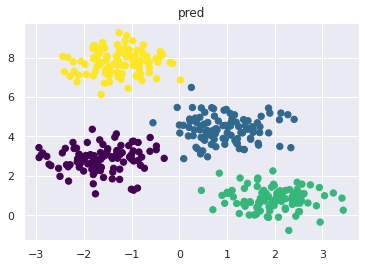

In [ ]:
labels =cp.asnumpy(tmm.predict(cp.asarray(X)))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.title("pred")

In [ ]:
import numpy as np
with open('testt.npy','rb') as f:
    y=np.load(f)
    o=np.load(f)
    X=np.load(f)

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)
from sklearn.metrics import confusion_matrix
def cluster_acc(predicted_labels,labels):
    cm = confusion_matrix(labels, predicted_labels)
    indexes = linear_assignment(_make_cost_m(cm))
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    return np.trace(cm2)/np.sum(cm2),np.diag(cm2) / np.sum(cm2,1),cm2

In [ ]:
tmm = tMixture(n_components=10,max_iter=700)
tmm.fit(cp.asarray(X))

n 10
297105.9881509037 loglikelihood
[[7748.29171131]]
n 10
285903.44106392044 loglikelihood
[[398.60316308]]
n 10
294442.7765333825 loglikelihood
[[177.1291299]]
n 10
289969.6113640341 loglikelihood
[[111.05489858]]
n 10
293973.56805279956 loglikelihood
[[66.93445051]]
n 10
290437.21698110405 loglikelihood
[[49.11644338]]
n 10
293909.7277645872 loglikelihood
[[34.26813063]]
n 10
290548.46322287543 loglikelihood
[[28.61861586]]
n 10
293892.6979719219 loglikelihood
[[23.94858523]]
n 10
290610.0341059834 loglikelihood
[[22.40940076]]
n 10
293884.0187423455 loglikelihood
[[20.91674692]]
n 10
290664.5924062116 loglikelihood
[[20.5514867]]
n 10
293878.3856659531 loglikelihood
[[19.95518752]]
n 10
290717.85981236096 loglikelihood
[[19.79570603]]
n 10
293874.32335959125 loglikelihood
[[19.47723954]]
n 10
290770.2376798503 loglikelihood
[[19.30745705]]
n 10
293871.1114510626 loglikelihood
[[19.10573331]]
n 10
290821.489768425 loglikelihood
[[18.90568904]]
n 10
293868.3201928986 loglikelihood
[

In [ ]:
labels=tmm.predict(cp.asarray(X))
cluster_acc(cp.asnumpy(labels),y)

293293.063986758 loglikelihood


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


(0.8718142857142858,
 array([0.99333623, 0.96445347, 0.96595136, 0.9634505 , 0.53150645,
        0.96499287, 0.98138453, 0.86013986, 0.93904762, 0.54498419]),
 array([[6857,    3,    3,    4,    2,    5,   24,    0,    4,    1],
        [   6, 7597,  151,    4,   13,    4,    4,   12,   18,   68],
        [  37,   27, 6752,   50,   16,    0,    3,   29,   43,   33],
        [  14,    3,   43, 6880,   40,   84,    1,    2,   54,   20],
        [   6,    0,    7,    0, 3627,    0,   13,    8,    7, 3156],
        [  35,    8,    6,   61,   18, 6092,   41,    0,   34,   18],
        [  13,    8,    3,    1,    3,   89, 6748,    0,    8,    3],
        [   9,    2,   34,    7,  315,    4,    0, 6273,    5,  644],
        [  19,    3,   16,  148,   29,   71,   34,    2, 6409,   94],
        [  15,    1,    8,  129, 2884,    9,    1,   63,   56, 3792]]))

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=10,n_init=30).fit(X)
labels = gmm.predict(X)


In [ ]:
cluster_acc(labels,y)

ValueError: ignored

In [ ]:
cp.sum(labels==9)

array(80)